In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sps
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

Скачиваем данные из файлов и посмотрим на то, как они выглядят

In [8]:
ftse = pd.read_csv('ftse100.csv', header=0, sep=',')
internet = pd.read_csv('internet-traffic.csv', header=0, sep=';')

Значения индекса FTSE

In [9]:
ftse.head(5)

,Unnamed: 0,date,ftse100
0,1,1984-04-02,-0.011461
1,2,1984-04-03,0.000000
2,3,1984-04-04,0.006208
3,4,1984-04-05,-0.005353
4,5,1984-04-06,0.000365


Информация о величине интернет-трафика в академической сети Великобритании

In [10]:
internet.head(5)

,Time,Internet traffic data (in bits) from an ISP
0,2004-11-19 09:30:00,64554.479
1,2004-11-19 10:30:00,71138.749
2,2004-11-19 11:30:00,77253.266
3,2004-11-19 12:30:00,77340.780
4,2004-11-19 13:30:00,79860.759


Проверим, есть ли в наших датафреймах пропущенные данные

In [12]:
print('Есть ли пропущенные значения в ряде значений индекса FTSE: ', ftse.isnull().values.any())
print('Есть ли пропущенные значения в ряде величины интернет-трафика: ', internet.isnull().values.any())

Есть ли пропущенные значения в ряде значений индекса FTSE:  False
Есть ли пропущенные значения в ряде величины интернет-трафика:  False


Пропущенных значений нет, отлично

Посмотрим как выглядят наши временные ряды

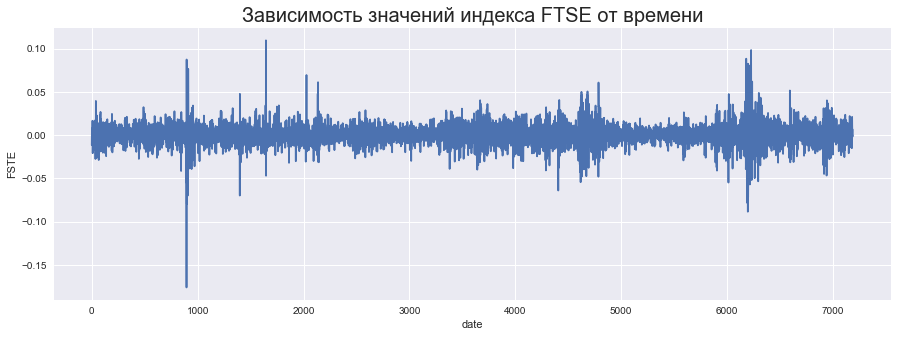

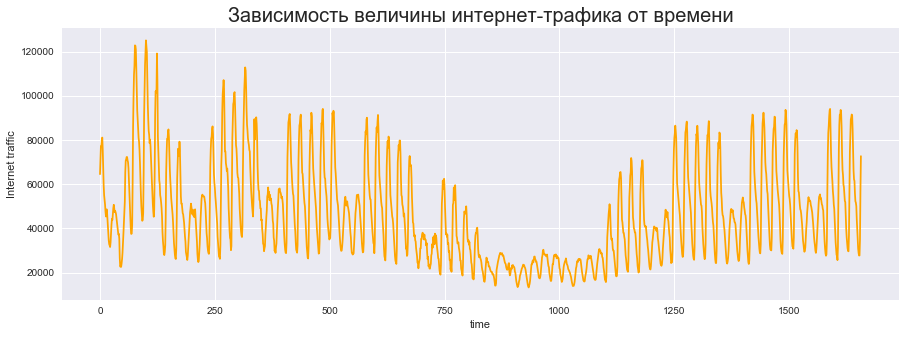

In [15]:
plt.figure(figsize=(15, 5))
plt.plot(ftse['ftse100'])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Зависимость значений индекса FTSE от времени', fontsize=20)
plt.show()
plt.figure(figsize=(15, 5))
plt.plot(internet['Internet traffic data (in bits) from an ISP'], c='orange')
plt.title('Зависимость величины интернет-трафика от времени',  fontsize=20)
plt.xlabel('time')
plt.ylabel('Internet traffic')
plt.show()

В обоих рядах видна разладка вида изменение дисперсии. Во втором ряде также видно уменьшение матожидания.

Найдем $P_\infty$ , то есть распределение до разладки. <br>
Для этого для ряда значений индекса FTSE будем рассматривать первые 800 элементов(так как визуально в это время разладок не происходило). Также заметим, что ряд значения FTSE имеет распределение похожее на нормальное, поэтому будем считать, что распределение нормальное. Определим параметры.

In [85]:
ftse_series = np.array(ftse['ftse100'])
ftse_mean = ftse_series[:800].mean()
ftse_std = ftse_series[:800].std()
print('a = {}, sigma = {}'.format(ftse_mean, ftse_std))

a = 0.000920357302615506, sigma = 0.00935808438075054


Теперь найдем $P_\infty$ для ряда интернет-трафика. <br>
Заметим, что в этом ряде присутствует ярко выраженная недельная и дневная сезонности. Сначала уберем их и посмотрим на то, что получилось.

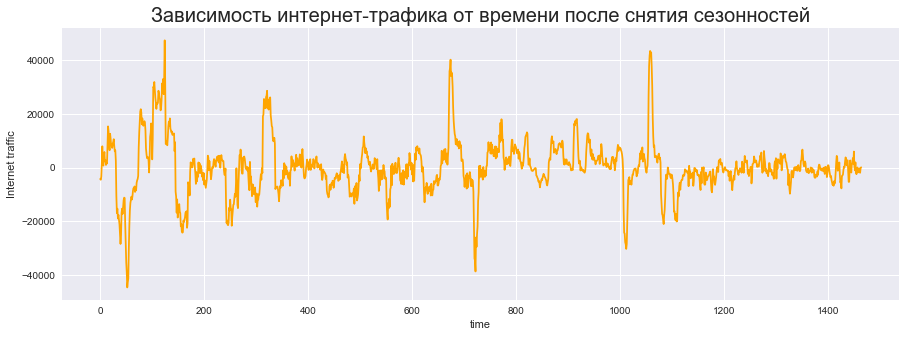

In [70]:
internet_series = np.array(internet['Internet traffic data (in bits) from an ISP'])
#дифференцируем по неделям
internet_series = internet_series[7*24:] - internet_series[:-7*24]
#дифференцируем по дням
internet_series = internet_series[24:] - internet_series[:-24]

plt.figure(figsize=(15, 5))
plt.plot(internet_series, c='orange')
plt.title('Зависимость интернет-трафика от времени после снятия сезонностей',  fontsize=20)
plt.xlabel('time')
plt.ylabel('Internet traffic')
plt.show()

Видим, что распределение полученного ряда отдаленно похоже на нормальное. Посмотрим на Q-Q plot. Предполагаем, что, распределение нормальное с параметрами loc и scale, найденными по первым 170 элементам ряда (визуально за это время разладки не произошло). Если Q-Q plot похож на прямую, но можем считать, что распределение действительно нормальное с такими параметрами.

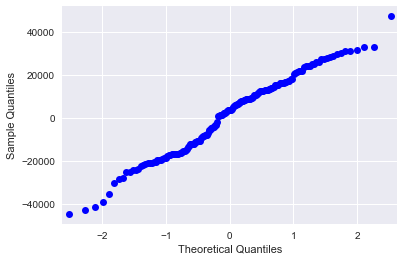

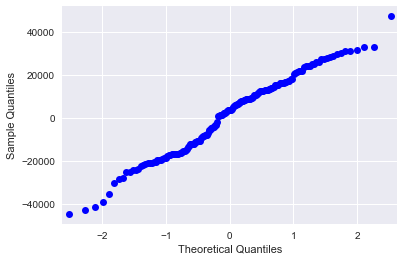

In [143]:
from statsmodels.graphics import gofplots
internet_mean = internet_series[:170].mean()
internet_std = internet_series[:170].std()
gofplots.qqplot(internet_series[:170], sps.norm, loc=internet_mean, scale=internet_std)

Как видим, график действительно похож на прямую. Поэтому будем считать, что распределение нормальное с подобранными выше параметрами.

In [144]:
print('a = {}, sigma = {}'.format(internet_mean, internet_std))

a = 1301.3741352941174, sigma = 18000.218496110672


Таким образом, мы определили $P_\infty$ для обоих рядов. <br>
Теперь поймем какие изменения считать значимыми. <br> <br>
**Для ряда значений FTSE** <br>
Еще раз посмотрим на то, как выглядит ряд

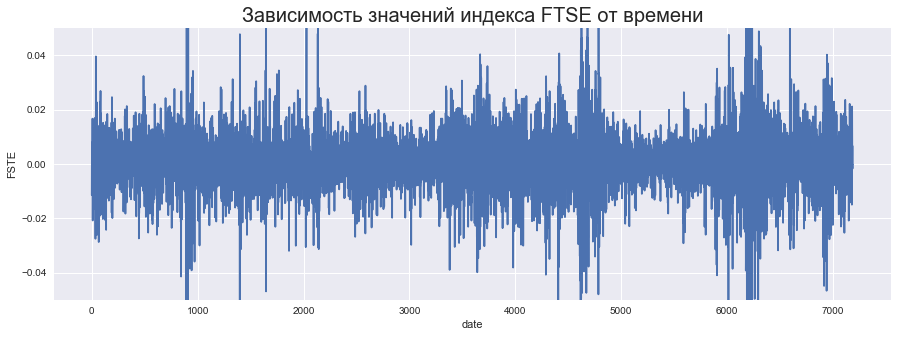

P_inf : a = 0.000920357302615506, sigma = 0.00935808438075054


In [76]:
plt.figure(figsize=(15, 5))
plt.plot(ftse['ftse100'])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.ylim(-0.05, 0.05)
plt.title('Зависимость значений индекса FTSE от времени', fontsize=20)
plt.show()
print('P_inf : a = {}, sigma = {}'.format(ftse_mean, ftse_std))

Визуально видим, что у нас есть 2 типа разладок: увеличение дисперсии (будем считать значимым увеличение больше, чем в 1.5 раза) и уменьшение дисперсии (будем считать значимым уменьшение больше, чем в 1.5 раза). <br>
Теперь реализуем нужные статистики : CUMSUM и Ширяева-Робертса. <br>
**CUMSUM** <br>
$$\gamma_n = sup_{\theta \ge 0} \frac{p_{\theta}(X_1, X_2, ..., X_n)}{p_{\infty}(X_1, X_2, ..., X_n)}$$ <br>
Будем реализовывать логарифм статистики: <br>
($f_0, f_\infty$ - плотности распределений $P_0$ и $P_{\infty}$)<br>
$$T_n = log(\gamma_n) = max(0, T_{n-1} + \zeta_n), \; \; \zeta_k = log \frac{f_0(X_k)}{f_\infty(X_k)}$$ 
$$T_0 = max(0, \zeta_0)$$ <br>
Момент объявления разладки: $\tau = inf(n \ge 0 : T_n \ge h)$

---------
**Статистика Ширяева-Робертса** <br>
$$\psi_n = (1 + \psi_{n-1}) e^{\zeta_n}, \; \; \zeta_k = log \frac{f_0(X_k)}{f_\infty(X_k)}$$
Момент объявления разладки: $\tau = inf(n \ge 0 : \psi_n \ge h)$

Реализуем данные статистики

In [97]:
def CUMSUM(X, f_0, f_inf):
    result = []
    zeta = np.log(f_0(X) / f_inf(X))
    result.append(max(0, zeta[0]))
    for i in range(1, len(X)):
        T_i = max(0, result[i-1] + zeta[i])
        result.append(T_i)
    return result

def Shiryaev_Roberts(X, f_0, f_inf):
    result = []
    zeta = np.log(f_0(X) / f_inf(X))
    result.append(np.e ** zeta[0])
    for i in range(1, len(X)):
        psi_i = (1 + result[i-1]) * (np.e**zeta[i])
        result.append(psi_i)
    return result

Посмотрим на первый вид разладки - увеличение дисперсии. Также для более понятной картины отрисуем логарифмированную статистику Ширяева-Робертса.

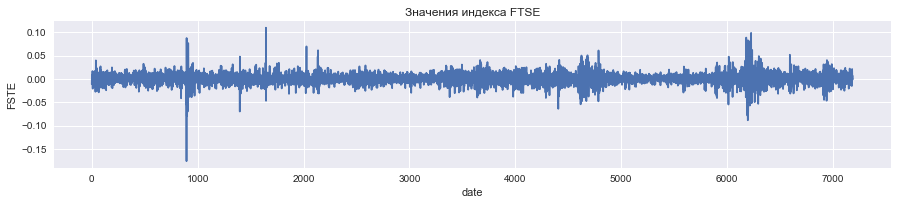

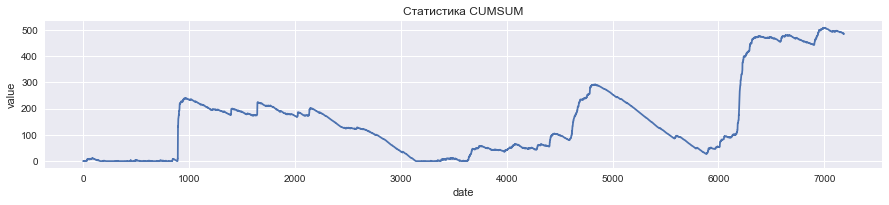

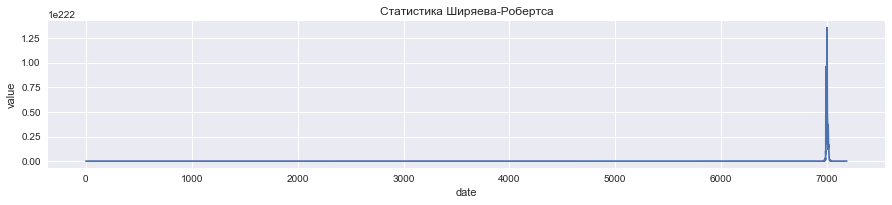

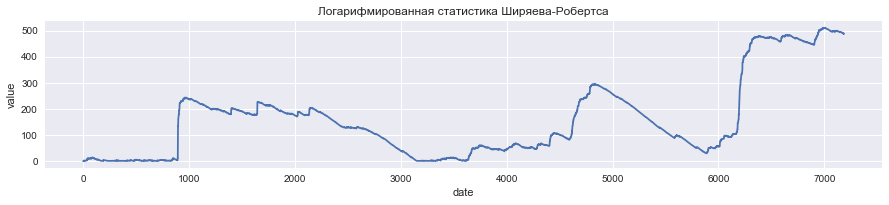

In [115]:
f_0 = sps.norm(loc=ftse_mean, scale=ftse_std*1.5).pdf
f_inf = sps.norm(loc=ftse_mean, scale=ftse_std).pdf
cumsum = CUMSUM(ftse_series, f_0, f_inf)
SR = Shiryaev_Roberts(ftse_series, f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(ftse_series)
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(SR)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика Ширяева-Робертса', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

Как видим, статистика CUMSUM и Ширяева-Робертса получились очень похожими. Кроме того, они обе обнаружили разладку в момент около 900. Найдем момент объявления разладки. Возьмем $h = 100$

In [116]:
h = 100
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR)

Время объявления разладки по статистике CUMSUM:  895
Время объявления разладки по статистике Ширяева-Робертса:  895


Посмотрим на отставание времени объявления разладки.

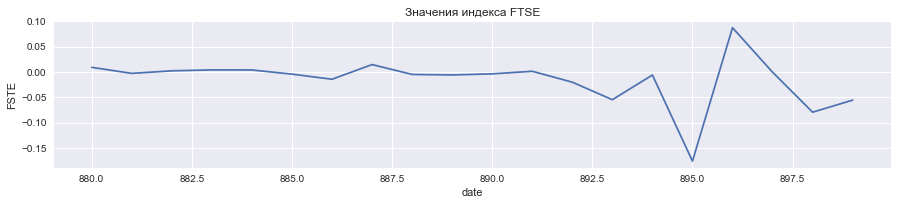

In [122]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(880, 900), ftse_series[880:900])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

Видим, что отставание составляет примерно 2 шага, что очень мало.

Теперь аналогично найдем последующие разладки данного типа(увеличение дисперсии).

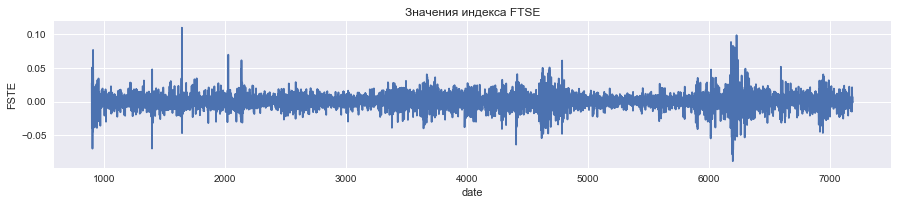

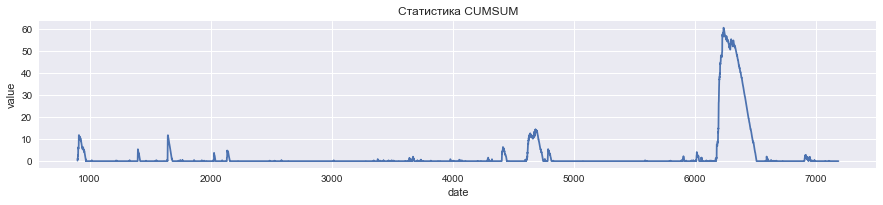

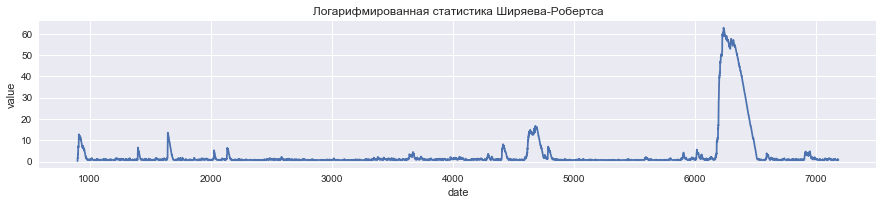

Время объявления разладки по статистике CUMSUM:  6237
Время объявления разладки по статистике Ширяева-Робертса:  6232


In [114]:
f_0 = sps.norm(loc=ftse_series[900:1200].mean(), scale=ftse_series[895:1200].std()*1.5).pdf
f_inf = sps.norm(loc=ftse_series[900:1200].mean(), scale=ftse_series[895:1200].std()).pdf
cumsum = CUMSUM(ftse_series[900:], f_0, f_inf)
SR = Shiryaev_Roberts(ftse_series[900:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(900, len(ftse_series)), ftse_series[900:])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(900, len(ftse_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(900, len(ftse_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 60
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 900)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 900)

Нашли еще одну разладку типа увеличение дисперсии, произошедшую примерно во время 6237. Посмотрим на отставание

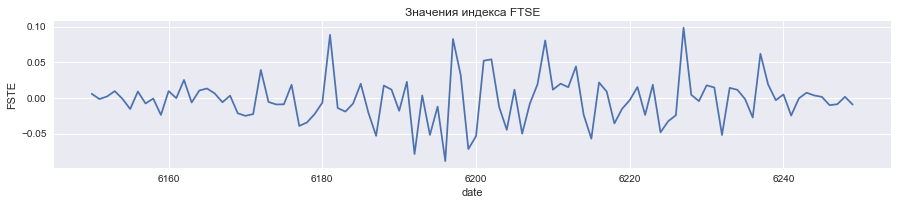

In [125]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(6150, 6250), ftse_series[6150:6250])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

Здесь отставание уже больше - примерно 35-40 шагов.

<br>
Теперь проделаем то же самое для второго вида разладки - уменьшение дисперсии. Визуально понимаем, что предполагаемое время первой разладки данного типа - около 2500.

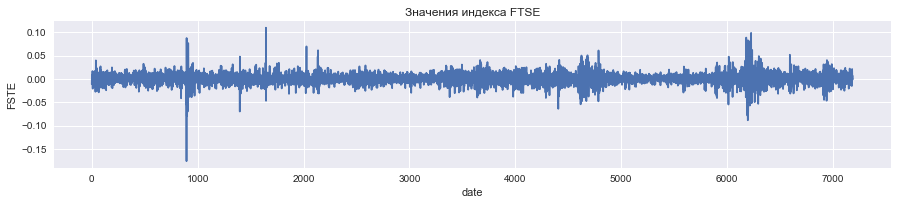

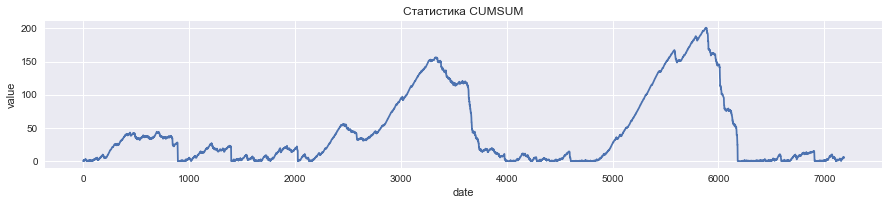

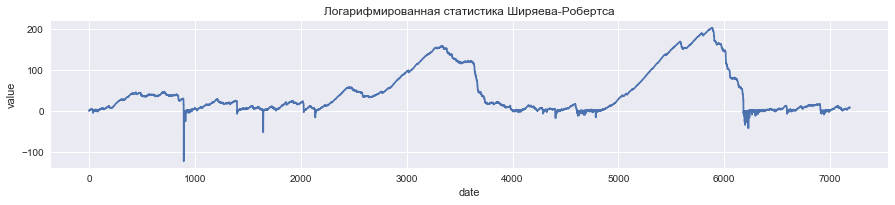

Время объявления разладки по статистике CUMSUM:  2867
Время объявления разладки по статистике Ширяева-Робертса:  2859


In [130]:
f_0 = sps.norm(loc=ftse_series[:1900].mean(), scale=ftse_series[:1900].std()/1.5).pdf
f_inf = sps.norm(loc=ftse_series[:1900].mean(), scale=ftse_series[:1900].std()).pdf
cumsum = CUMSUM(ftse_series, f_0, f_inf)
SR = Shiryaev_Roberts(ftse_series, f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(ftse_series)), ftse_series)
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(ftse_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(ftse_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 60
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR)

Посмотрим на задержку при подаче сигнала.

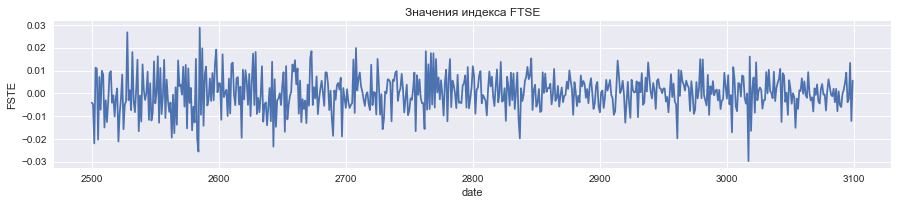

In [132]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(2500, 3100), ftse_series[2500:3100])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

В данном случае, задержка составляет около 5-10.

Найдем последующие разладки данного типа.

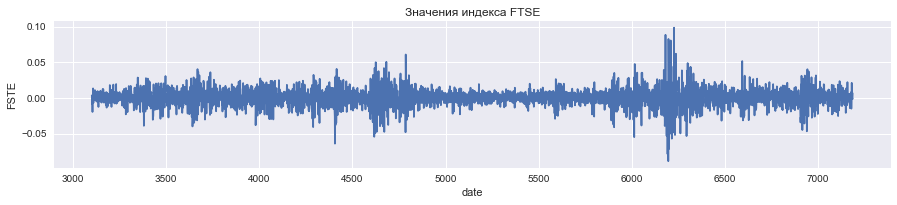

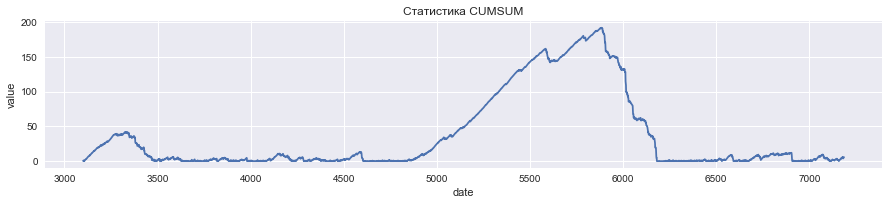

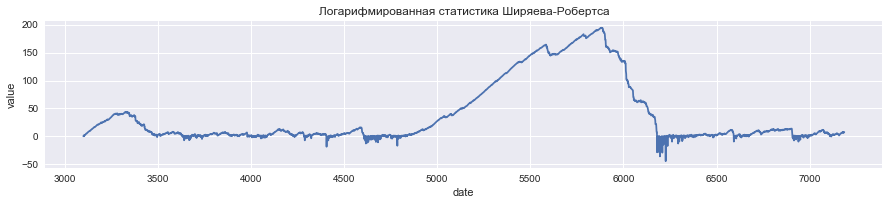

Время объявления разладки по статистике CUMSUM:  5189
Время объявления разладки по статистике Ширяева-Робертса:  5176


In [136]:
f_0 = sps.norm(loc=ftse_series[3100:4500].mean(), scale=ftse_series[3100:4500].std()/1.5).pdf
f_inf = sps.norm(loc=ftse_series[3100:4500].mean(), scale=ftse_series[3100:4500].std()).pdf
cumsum = CUMSUM(ftse_series[3100:], f_0, f_inf)
SR = Shiryaev_Roberts(ftse_series[3100:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(3100, len(ftse_series)), ftse_series[3100:])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(3100, len(ftse_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(3100, len(ftse_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 60
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 3100)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 3100)

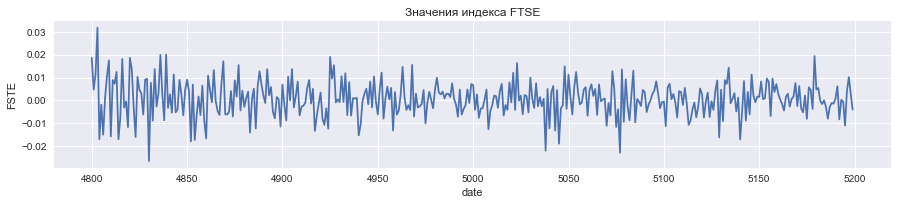

In [138]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(4800, 5200), ftse_series[4800:5200])
plt.xlabel('date')
plt.ylabel('FSTE')
plt.title('Значения индекса FTSE', fontsize=12)
plt.show()

Здесь задержка получилась около 200.

Заметим, что обе статистики выявили самые очевидные разладки. Однако во время 4600-4800 тоже скорей всего произошла разладка вида увеличение дисперсии. Однако ни та, ни другая статистика эту разладку не обнаружили.

**Для ряда интернет-трафика после сезонных дифференцирований** <br>
Еще раз посмотрим на то, как выглядит ряд

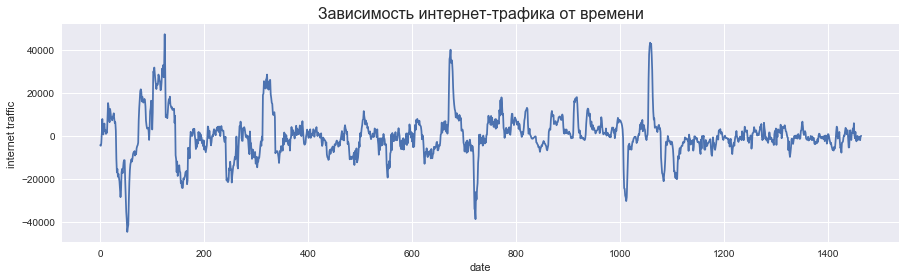

P_inf : a = 1301.3741352941174, sigma = 18000.218496110672


In [202]:
plt.figure(figsize=(15, 4))
plt.plot(internet_series)
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Зависимость интернет-трафика от времени', fontsize=16)
plt.show()
print('P_inf : a = {}, sigma = {}'.format(internet_mean, internet_std))

Из графика видим, что у нас присутствуют также 2 типа разладок: уменьшение и увеличение дисперсии. Изменение мат. ожидания особо не наблюдается.  <br>
**1)Увеличение дисперсии**

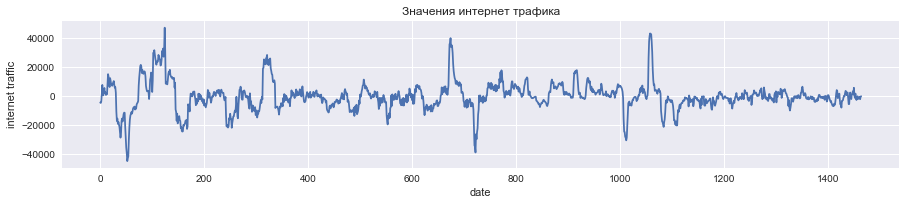

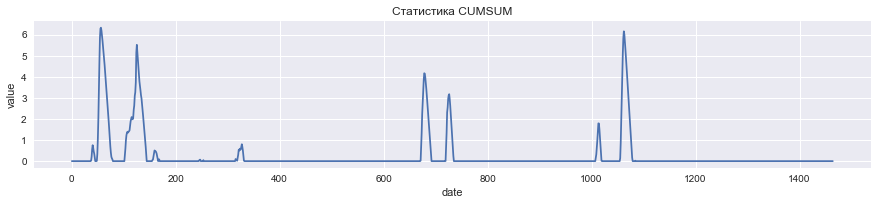

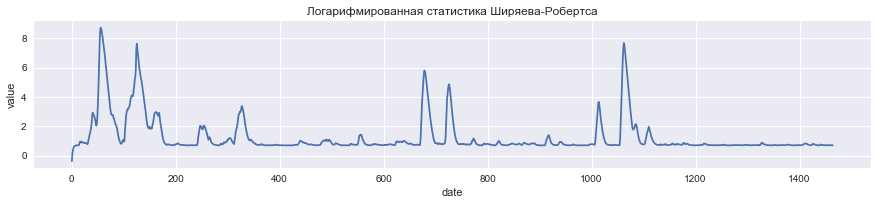

Время объявления разладки по статистике CUMSUM:  52
Время объявления разладки по статистике Ширяева-Робертса:  50


In [154]:
f_0 = sps.norm(loc=internet_series[:170].mean(), scale=internet_series[:170].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[:170].mean(), scale=internet_series[:170].std()).pdf
cumsum = CUMSUM(internet_series, f_0, f_inf)
SR = Shiryaev_Roberts(internet_series, f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), internet_series)
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 3
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR)


Как видим, первая разладка произошла почти сразу.

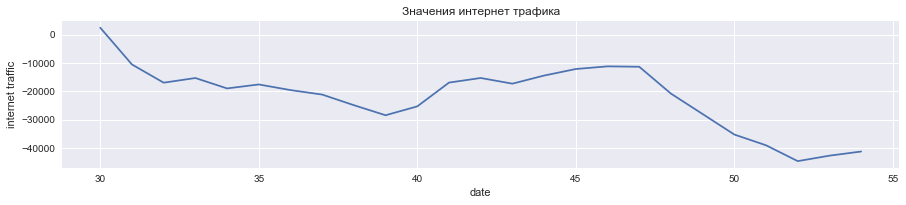

In [156]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(30, 55), internet_series[30:55])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка совсем небольшая - 2-3 шага.

Ищем дальше

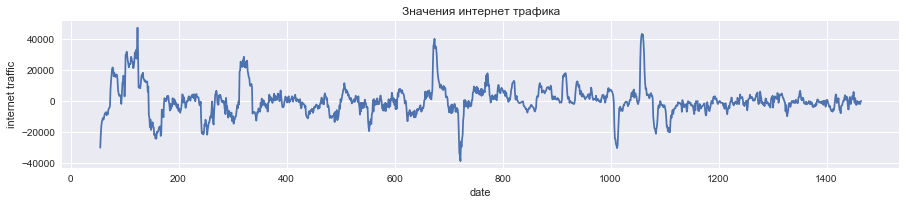

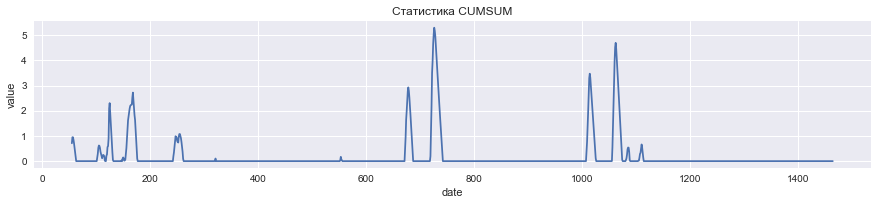

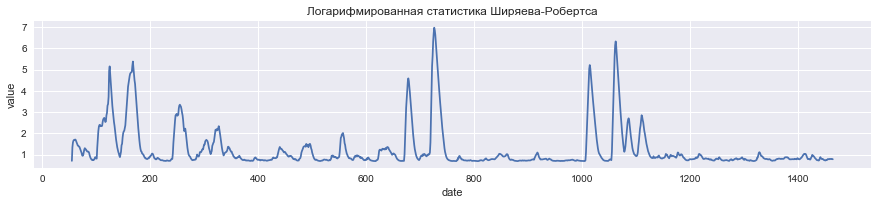

Время объявления разладки по статистике CUMSUM:  124
Время объявления разладки по статистике Ширяева-Робертса:  104


In [160]:
f_0 = sps.norm(loc=internet_series[55:170].mean(), scale=internet_series[55:170].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[55:170].mean(), scale=internet_series[55:170].std()).pdf
cumsum = CUMSUM(internet_series[55:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[55:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(55, len(internet_series)), internet_series[55:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(55, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(55, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 2
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 55)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 55)



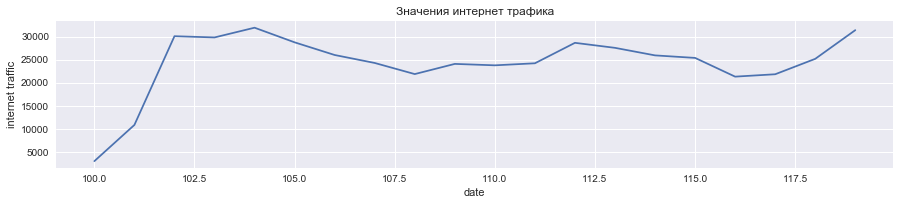

In [163]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(100, 120), internet_series[100:120])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка у статистики CUMSUM состовляет около 20 шагов, задержка у статистики Ширяева-Робертса - 1-2 шага.

Ищем следующую разладку

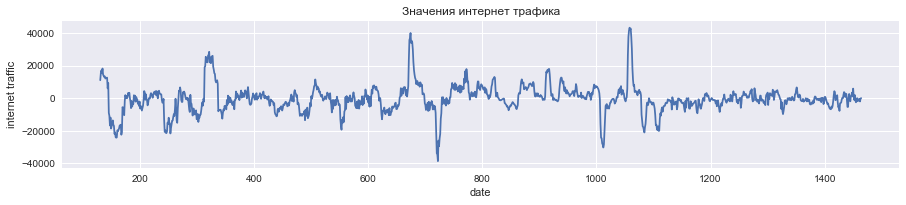

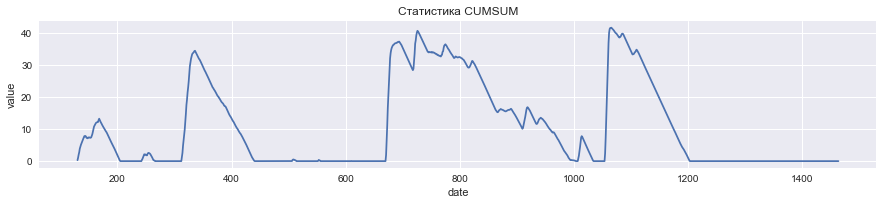

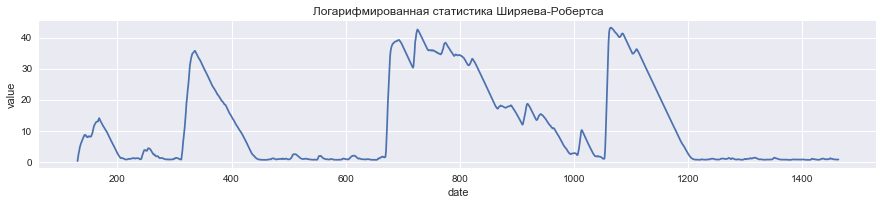

Время объявления разладки по статистике CUMSUM:  323
Время объявления разладки по статистике Ширяева-Робертса:  322


In [168]:
f_0 = sps.norm(loc=internet_series[130:300].mean(), scale=internet_series[130:300].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[130:300].mean(), scale=internet_series[130:300].std()).pdf
cumsum = CUMSUM(internet_series[130:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[130:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(130, len(internet_series)), internet_series[130:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(130, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(130, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 20
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 130)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 130)




Такс, нашли еще одну разладку. Посмотрим на отставание

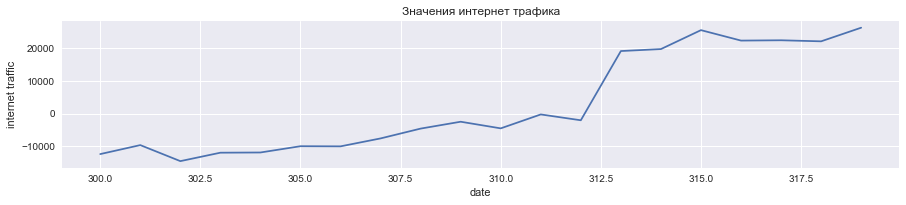

In [169]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(300, 320), internet_series[300:320])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Оставание у обоих статистик составляет примерно 10 шагов.

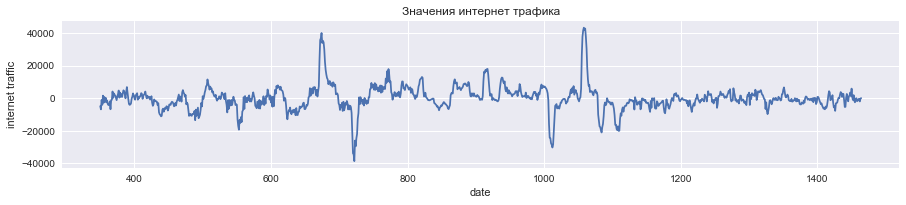

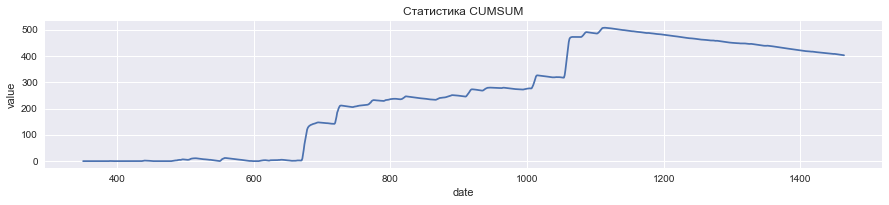

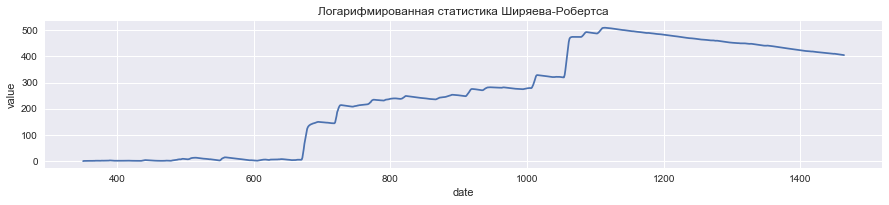

Время объявления разладки по статистике CUMSUM:  677
Время объявления разладки по статистике Ширяева-Робертса:  677


In [171]:
f_0 = sps.norm(loc=internet_series[350:600].mean(), scale=internet_series[350:600].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[350:600].mean(), scale=internet_series[350:600].std()).pdf
cumsum = CUMSUM(internet_series[350:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[350:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(350, len(internet_series)), internet_series[350:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(350, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(350, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 100
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 350)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 350)


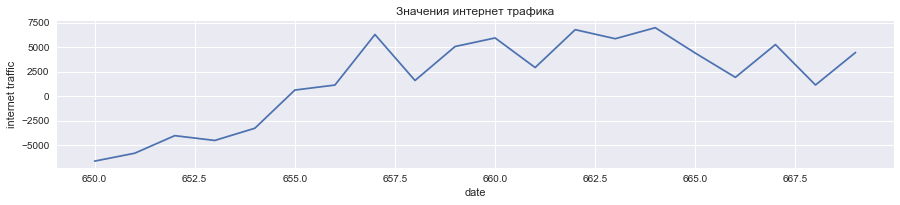

In [172]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(650, 670), internet_series[650:670])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка примерно 20 шагов. <br>
Ищем слудующую

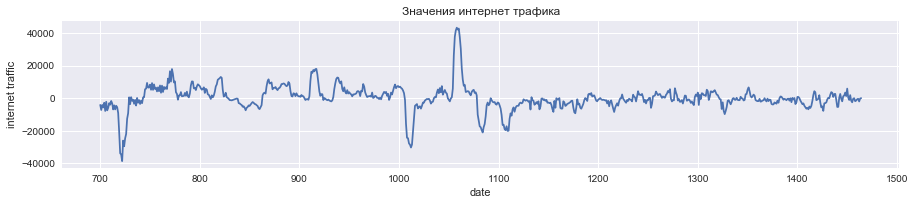

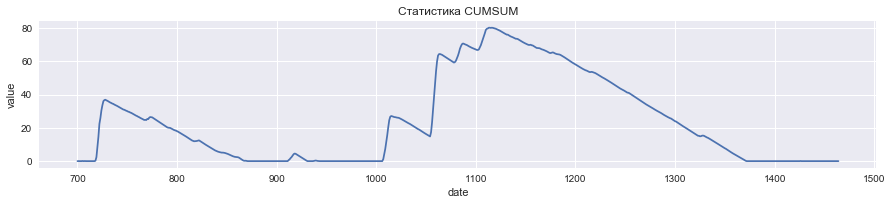

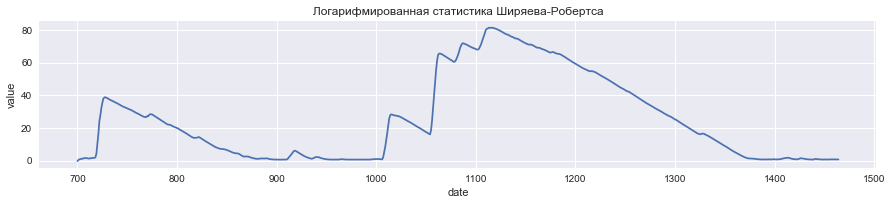

Время объявления разладки по статистике CUMSUM:  724
Время объявления разладки по статистике Ширяева-Робертса:  724


In [174]:
f_0 = sps.norm(loc=internet_series[700:1000].mean(), scale=internet_series[700:1000].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[700:1000].mean(), scale=internet_series[700:1000].std()).pdf
cumsum = CUMSUM(internet_series[700:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[700:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(700, len(internet_series)), internet_series[700:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(700, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(700, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 30
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 700)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 700)



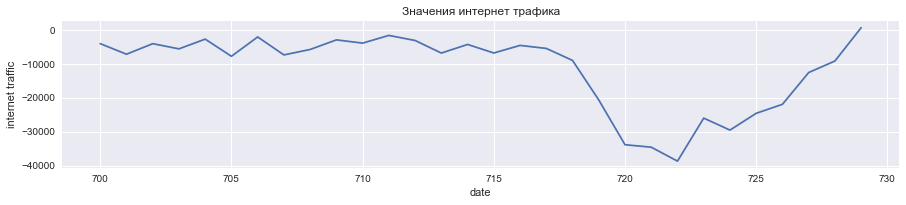

In [175]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(700, 730), internet_series[700:730])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка по обеим статистикам около 5-10 шагов <br>
Ищем следующую разладку

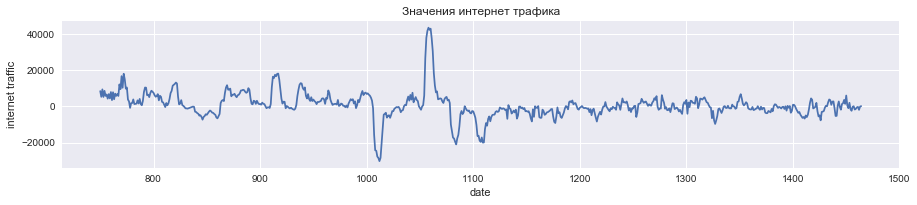

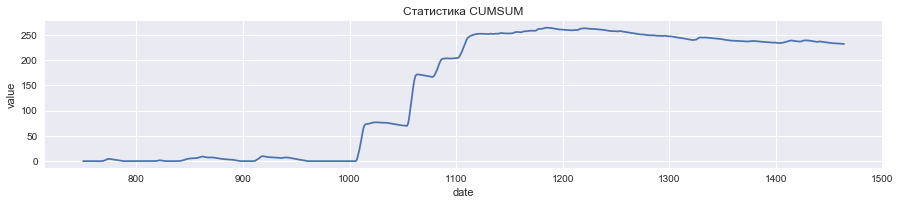

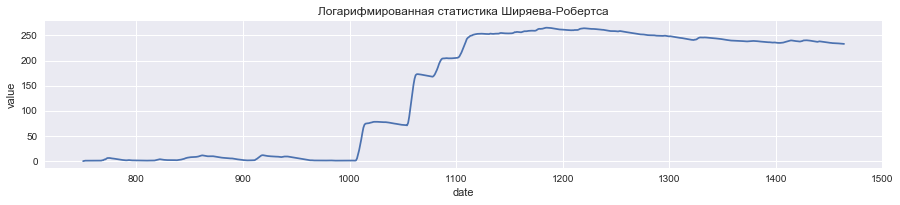

Время объявления разладки по статистике CUMSUM:  1057
Время объявления разладки по статистике Ширяева-Робертса:  1057


In [177]:
f_0 = sps.norm(loc=internet_series[750:1000].mean(), scale=internet_series[750:1000].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[750:1000].mean(), scale=internet_series[750:1000].std()).pdf
cumsum = CUMSUM(internet_series[750:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[750:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(750, len(internet_series)), internet_series[750:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(750, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(750, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 100
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 750)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 750)




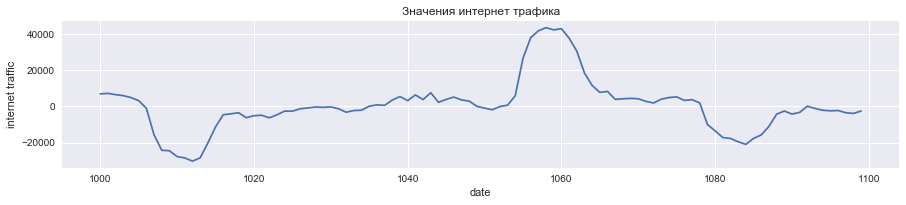

In [179]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(1000, 1100), internet_series[1000:1100])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка около 50 шагов. <br>
Идем дальше

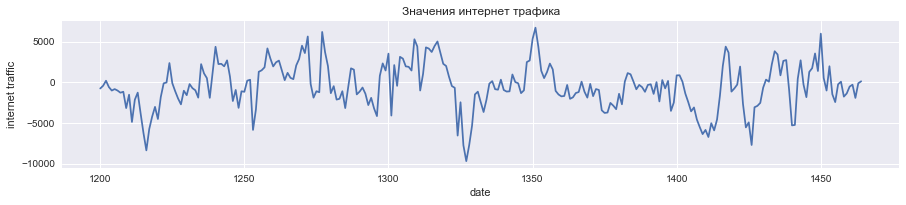

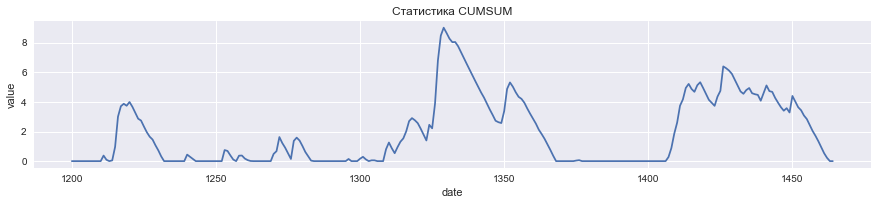

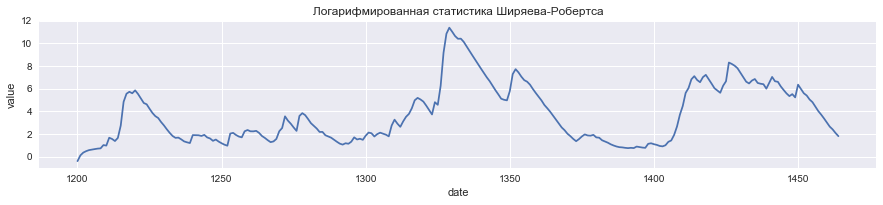

Время объявления разладки по статистике CUMSUM:  1328
Время объявления разладки по статистике Ширяева-Робертса:  1327


In [182]:
f_0 = sps.norm(loc=internet_series[1200:1400].mean(), scale=internet_series[1200:1400].std()*1.5).pdf
f_inf = sps.norm(loc=internet_series[1200:1400].mean(), scale=internet_series[1200:1400].std()).pdf
cumsum = CUMSUM(internet_series[1200:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[1200:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(1200, len(internet_series)), internet_series[1200:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(1200, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(1200, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 8
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 1200)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 1200)





**2) уменьшение дисперсии**

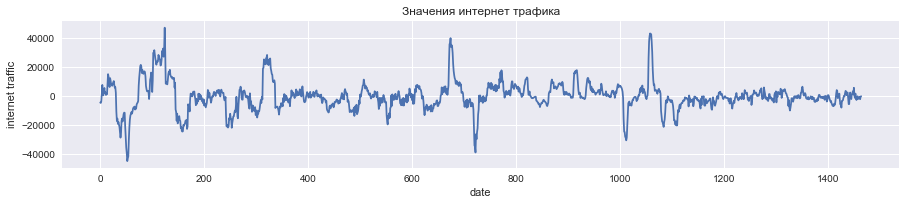

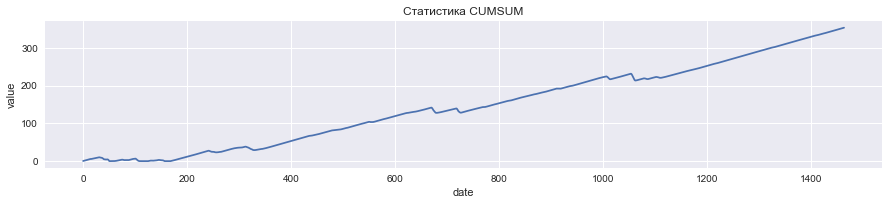

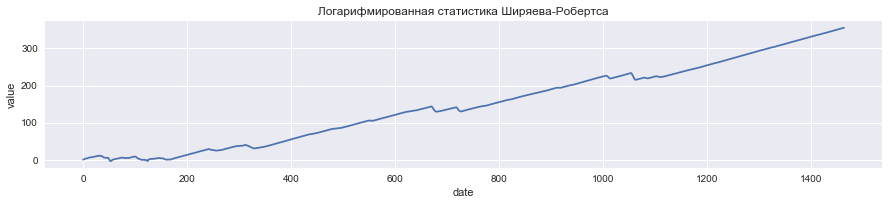

Время объявления разладки по статистике CUMSUM:  392
Время объявления разладки по статистике Ширяева-Робертса:  388


In [185]:
f_0 = sps.norm(loc=internet_series[:170].mean(), scale=internet_series[:170].std()/1.5).pdf
f_inf = sps.norm(loc=internet_series[:170].mean(), scale=internet_series[:170].std()).pdf
cumsum = CUMSUM(internet_series, f_0, f_inf)
SR = Shiryaev_Roberts(internet_series, f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), internet_series)
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 50
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR)



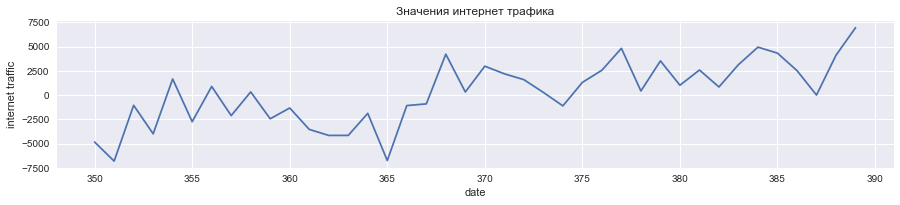

In [187]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(350, 390), internet_series[350:390])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка около 20

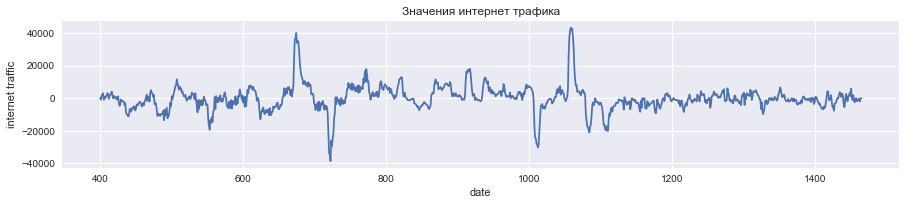

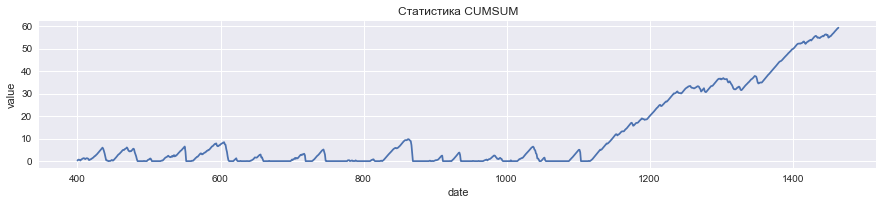

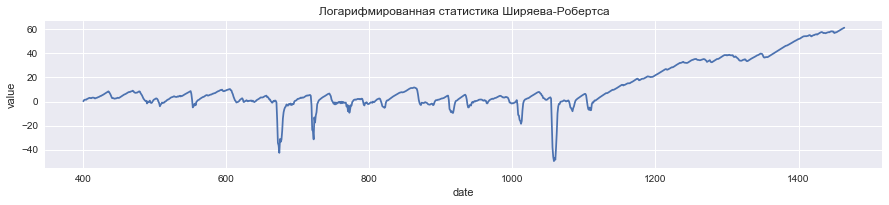

Время объявления разладки по статистике CUMSUM:  1201
Время объявления разладки по статистике Ширяева-Робертса:  1187


In [189]:
f_0 = sps.norm(loc=internet_series[400:600].mean(), scale=internet_series[400:600].std()/1.5).pdf
f_inf = sps.norm(loc=internet_series[400:600].mean(), scale=internet_series[400:600].std()).pdf
cumsum = CUMSUM(internet_series[400:], f_0, f_inf)
SR = Shiryaev_Roberts(internet_series[400:], f_0, f_inf)

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(400, len(internet_series)), internet_series[400:])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(400, len(internet_series)), cumsum)
plt.xlabel('date')
plt.ylabel('value')
plt.title('Статистика CUMSUM', fontsize=12)
plt.show()

plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(400, len(internet_series)), np.log(SR))
plt.xlabel('date')
plt.ylabel('value')
plt.title('Логарифмированная статистика Ширяева-Робертса', fontsize=12)
plt.show()

h = 20
for i in range(len(cumsum)):
    if cumsum[i] >= h and cumsum[i - 1] < h:
        tau_cumsum = i
        break
        
for i in range(len(SR)):
    if np.log(SR[i]) >= h and np.log(SR[i - 1]) < h:
        tau_SR = i
        break
        
print('Время объявления разладки по статистике CUMSUM: ', tau_cumsum + 400)
print('Время объявления разладки по статистике Ширяева-Робертса: ', tau_SR + 400)




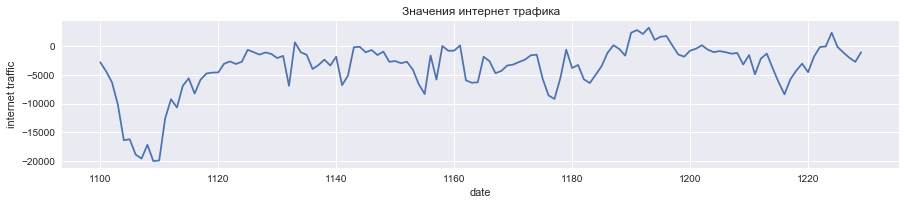

In [193]:
plt.figure(figsize=(15, 2.7))
plt.plot(np.arange(1100, 1230), internet_series[1100:1230])
plt.xlabel('date')
plt.ylabel('internet traffic')
plt.title('Значения интернет трафика', fontsize=12)
plt.show()

Задержка по статистике CUMSUM около 80, по статистике Ширяева-Робертса около 70 шагов

**Вывод:** Увидели, что обе статистики неплохо распознают разладки. Иногда задержка сигнала составляет 1-2 шага, иногда около 100, однако в среднем она равна примерно 30, что не очень много. В основном, графики обеих статистик очень похожи друг на друга и сигнал о разладке подают примерно в одно и то же время, однако иногда попадались случаи, когда статистика Ширяева-Робертса давала сигнал о разладке чуть раньше. <br>

Эх, стоило бы написать отдельную функцию отрисовки графиков, но эта идея пришла ко мне в голову слишком поздно:(